# Take a dataset, do an n-fold creation of training and testing data, use an ensemble to combine them again

In [1]:
from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot
import pandas as pd
import numpy as np
from gumps.studies.batch_study import AbstractBatchStudy
from typing import Callable

from gumps.solvers.sampler import SamplerSolverParameters
from gumps.apps.parametric_sweep import ParametricSweepApp

import matplotlib.pyplot as plt

from gumps.solvers.regressors.pytorch_regressor import TorchMultiLayerPerceptronRegressor, TorchMultiLayerPerceptronRegressionParameters
from gumps.solvers.regressors.xgboost_regressor import XGBoostRegressor, XGBoostParameters
from gumps.solvers.regressors.ensemble_regressor import EnsembleRegressor, EnsembleParameters
from gumps.solvers.mutual_info import MutualSettings, MutualInfoRegression
from gumps.solvers.regressors.regression_solver import OptunaParameters

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create a basic dataset

In [2]:
# a will require log-scaling
# b will require linear-scaling
# c will range from -1 to 1
# d will require logs-scaling

# w will require linear scaling
# x will require log-scaling
# y will range from 0 to 1
# z will require log-scaling

class SyntheticBatchStudy(AbstractBatchStudy):
    "batch version of sphere study (designed to approximate surrogate model)"

    def __init__(self, *, model_variables:dict):
        self.model_variables = model_variables

    def start(self):
        "initialize this study"

    def stop(self):
        "handle shutdown tasks"

    def run(self, input_data:pd.DataFrame, processing_function:Callable|None=None) -> pd.DataFrame:
        "run the batch simulation"
        output_data = pd.DataFrame()
        output_data["w"] = np.log(input_data["a"]) * input_data['b']
        output_data["x"] = np.exp(input_data['b'])
        output_data["y"] = input_data['c']**2
        output_data["z"] = input_data['d'] * input_data['b']

        self.save_results(input_data, output_data)

        if processing_function is None:
            return output_data
        else:
            return processing_function(output_data)

In [3]:
def get_all(frame:pd.DataFrame) -> pd.DataFrame:
    "processing function to get the total from the dataframe"
    return frame

In [4]:
batch = SyntheticBatchStudy(model_variables={})

parameters = SamplerSolverParameters(
    number_of_samples = 200,
    lower_bound = {'a':1e0, 'b':1, 'c':-1, 'd':1e-7},
    upper_bound = {'a':1e7, 'b':100, 'c':1, 'd':1e-2},
    sampler = "sobol"
    )

app = ParametricSweepApp(parameters=parameters,
        processing_function=get_all,
        directory=None,
        batch=batch)
app.run()

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [5]:
mutual_settings = MutualSettings(app.factors, app.responses, n_neighbors='auto')
mutual = MutualInfoRegression(mutual_settings)
mutual.fit()

In [6]:
mutual.score()

,w,x,y,z
a,0.086873,0.000000,0.000000,0.000000
b,0.664330,3.280174,0.000000,0.036918
c,0.000000,0.000000,1.858987,0.000000
d,0.000000,0.000000,0.000000,0.858818


<Axes: >

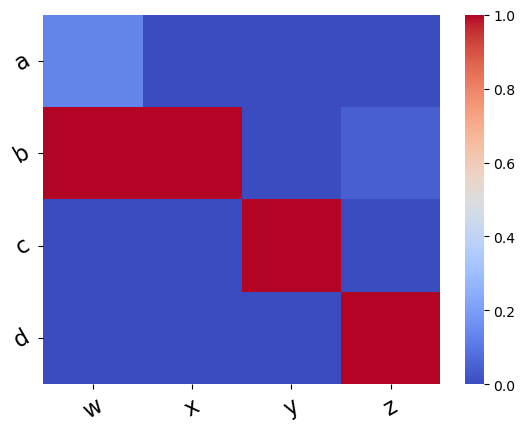

In [7]:
mutual.plot()

## Build a pyTorch regressor that we can put into the ensemble

In [8]:
reg_data = XGBoostParameters(input_data=app.factors, output_data=app.responses, verbosity=1)

regressor_inner = XGBoostRegressor(reg_data)

# Build an ensemble regressor

In [9]:
ensemble_parameters = EnsembleParameters(input_data=app.factors,
                                         output_data=app.responses,
                                        regressor = regressor_inner,
                                        number_regressors = 5,
                                        validation_fraction = 0.25)

ensemble = EnsembleRegressor(ensemble_parameters)
ensemble.fit()

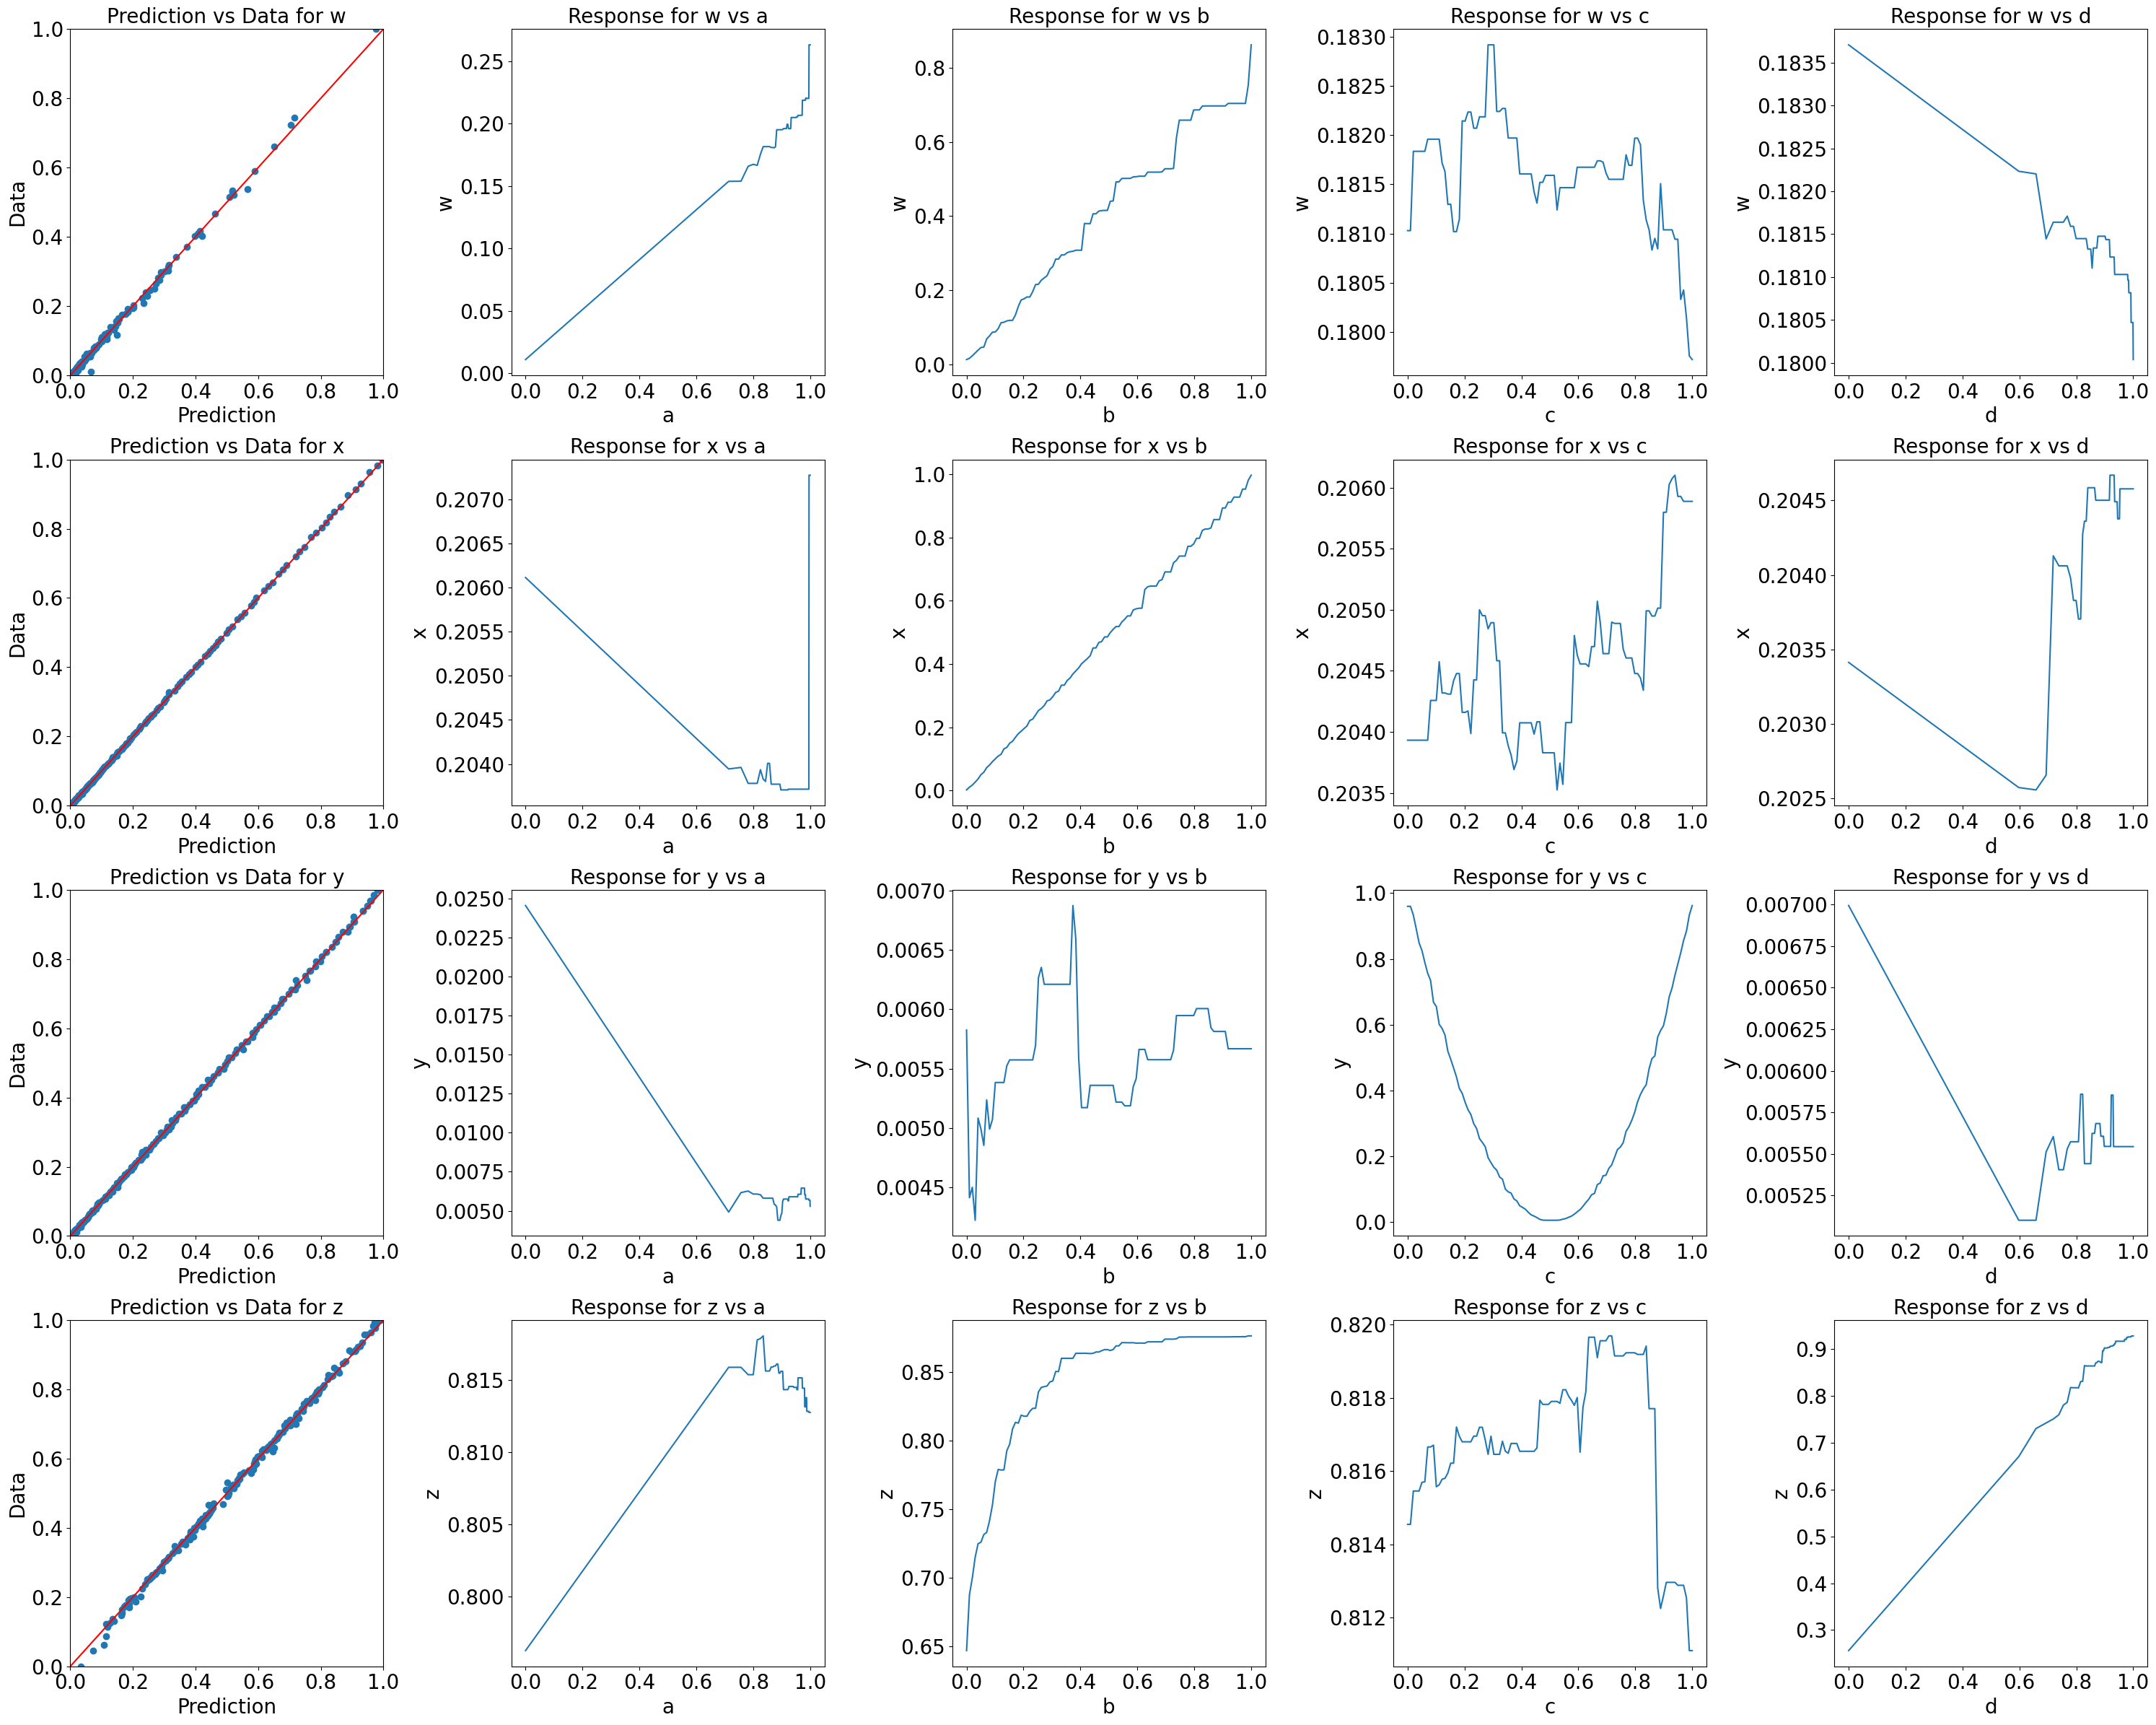

In [10]:
params_full = RegressorPlotParameters(ensemble, app.factors.mean(), app.factors.min(), app.factors.max())
reg_plot_full = RegressorPlot(params_full)
reg_plot_full.plot_scaled()

In [11]:
for idx, regressor in enumerate(ensemble.regressors):
    print(f'Regressor {idx} nrmse: {regressor.error_metrics()["nrmse"]}')

Regressor 0 nrmse: 0.018088565266295157
Regressor 1 nrmse: 0.016262412201340098
Regressor 2 nrmse: 0.04863860526238439
Regressor 3 nrmse: 0.04416344841356822
Regressor 4 nrmse: 0.020477352812592105


In [12]:
#make a regressor against the full data
mlp_reg_data_full = XGBoostParameters(input_data=app.factors, output_data=app.responses)

mlp_regressor_full = XGBoostRegressor(mlp_reg_data_full)
mlp_regressor_full.fit()

In [13]:
print(f"Error: {mlp_regressor_full.error_metrics()['nrmse']}")

Error: 0.011096790936296752


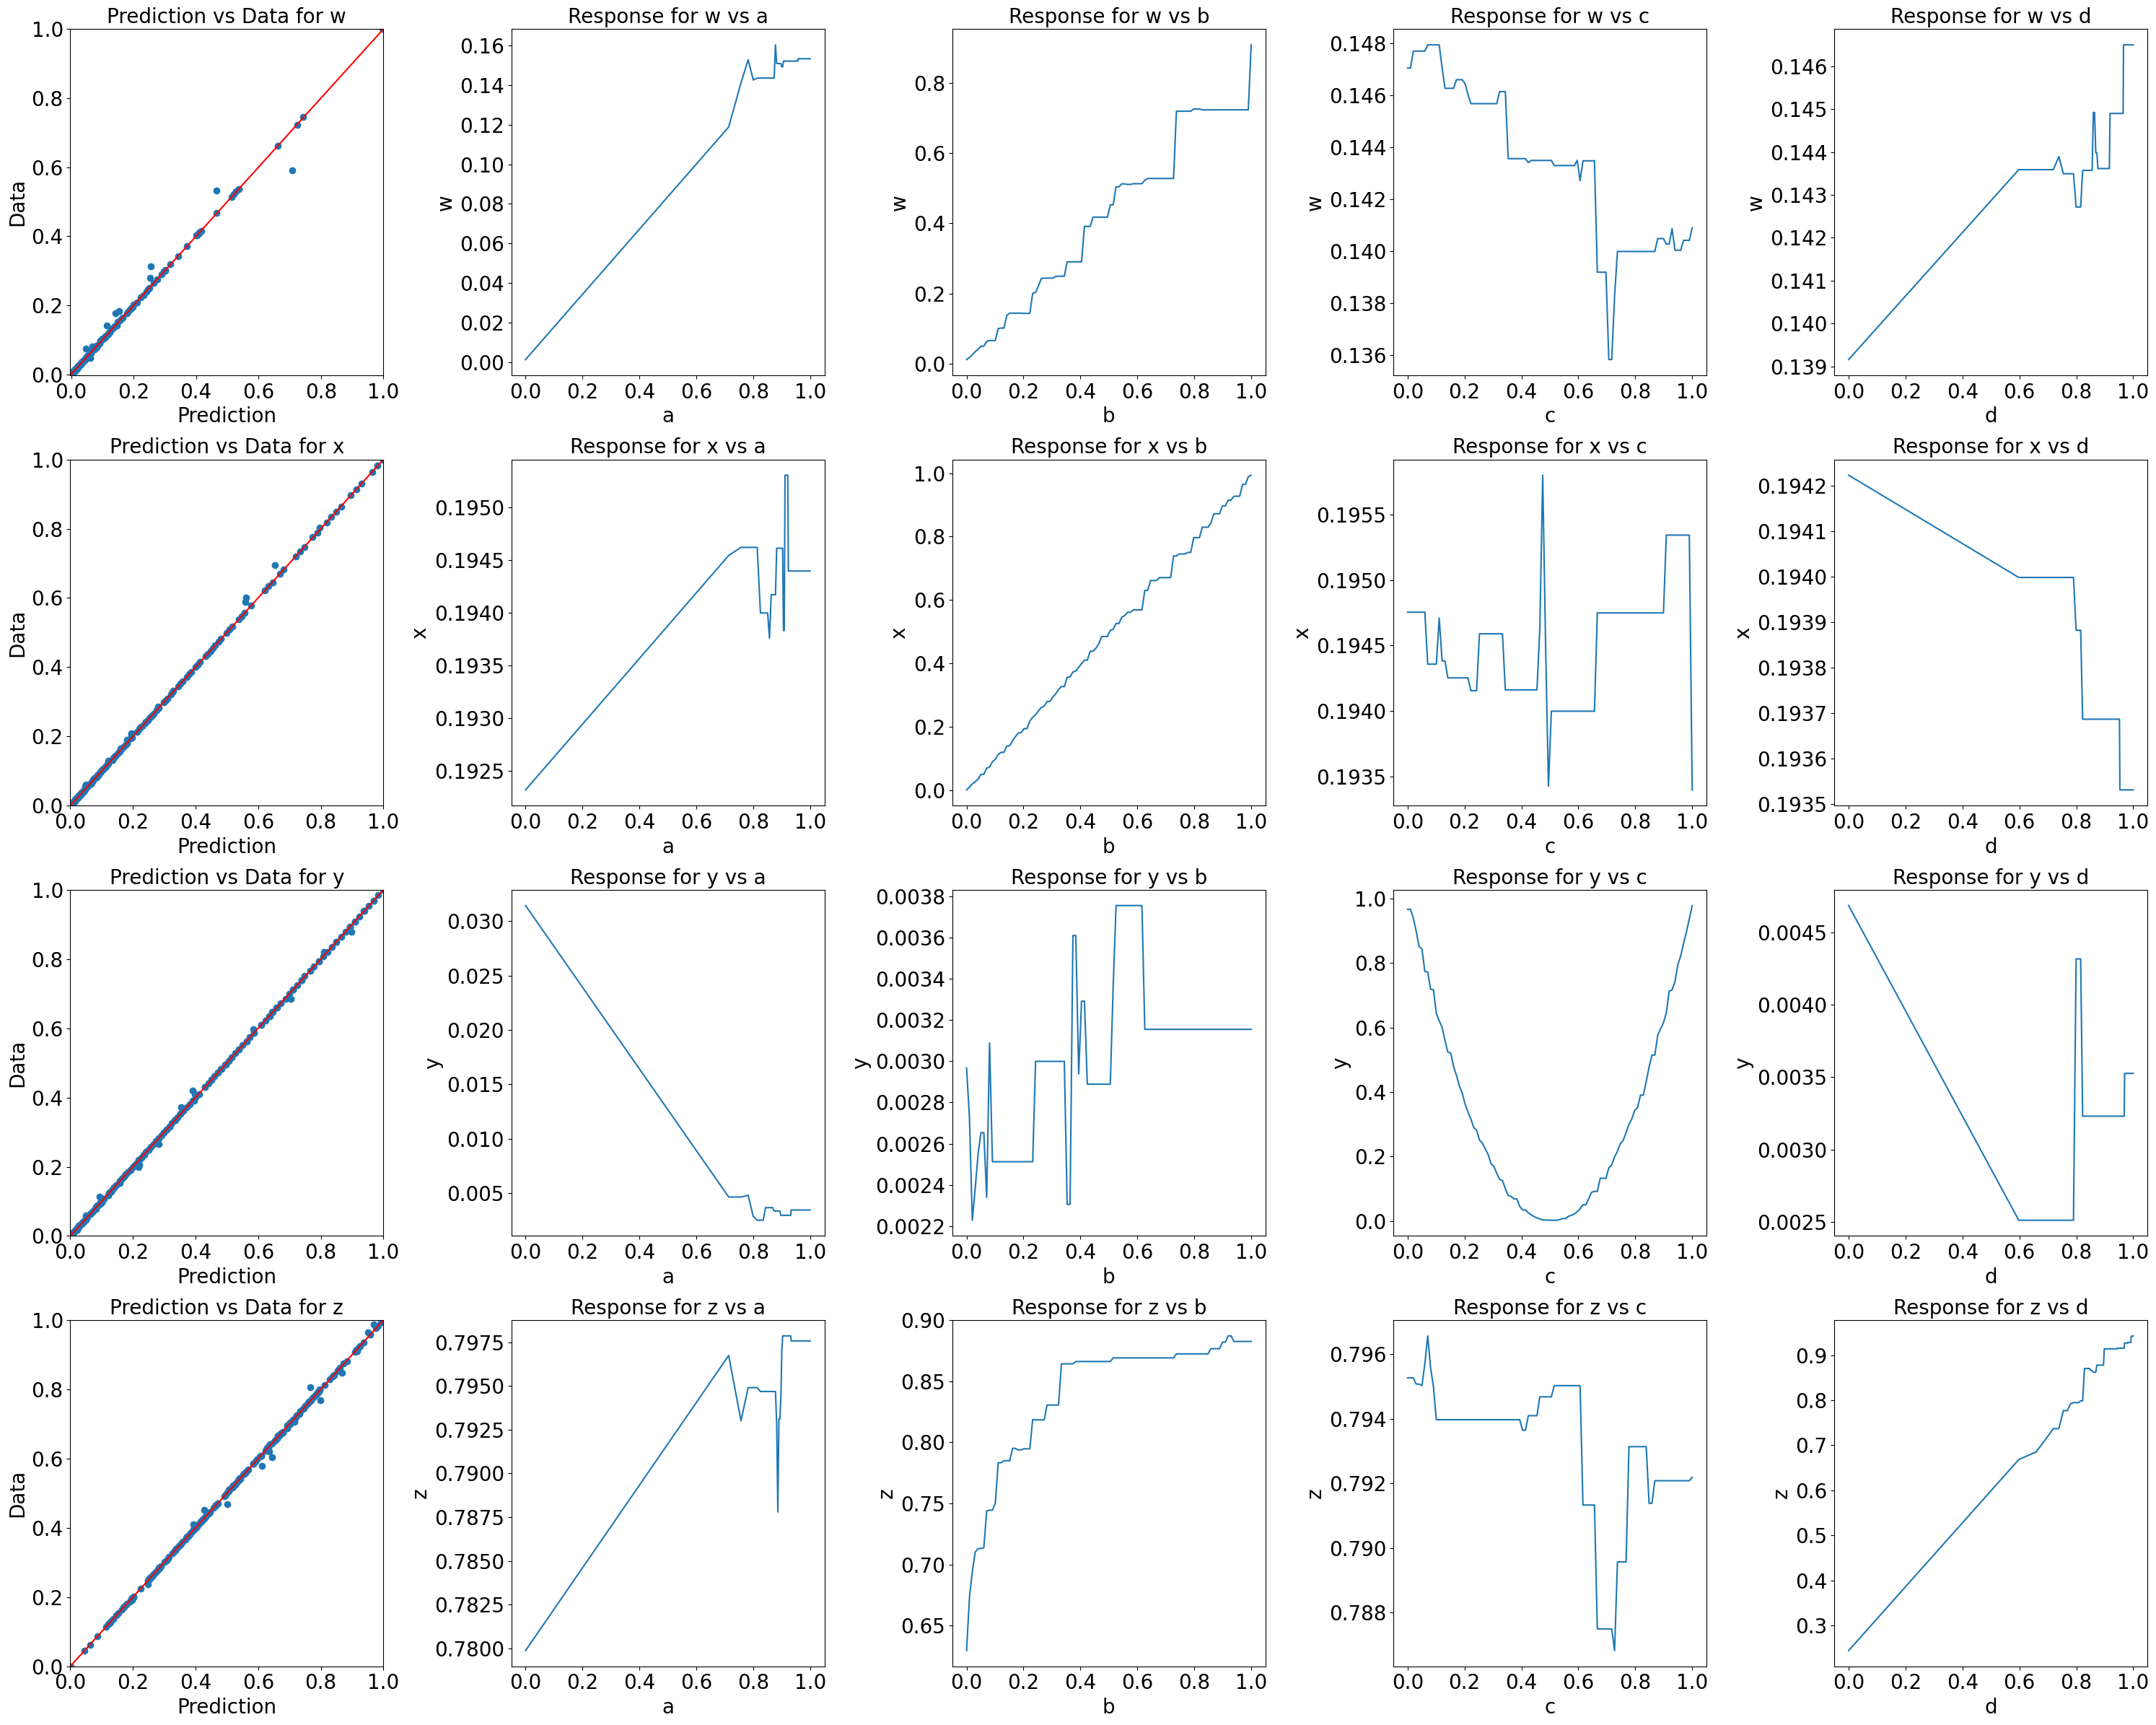

In [14]:
params_full = RegressorPlotParameters(mlp_regressor_full, app.factors.mean(), app.factors.min(), app.factors.max())
reg_plot_full = RegressorPlot(params_full)
reg_plot_full.plot_scaled()

In [15]:
predictions_full = mlp_regressor_full.predict(app.factors)

# Auto tune the regressor

In [16]:
ensemble.regressor.tune_parameters()

{'booster': 'gbtree',
 'gamma': None,
 'max_depth': None,
 'min_child_weight': None,
 'n_estimators': 100,
 'num_parallel_tree': None,
 'learning_rate': None}

In [17]:
ensemble.error_metrics()

score                                 9.828308e-01
r2_score                              9.828308e-01
mean_squared_error                    2.548500e+79
mse                                   2.548500e+79
root_mean_squared_error               5.048267e+39
rmse                                  5.048267e+39
normalized_mean_squared_error         2.677677e-04
nmse                                  2.677677e-04
normalized_root_mean_squared_error    1.636361e-02
nrmse                                 1.636361e-02
dtype: float64

In [18]:
settings = OptunaParameters(number_of_trials=100)

In [19]:
ensemble.auto_tune(settings)

[I 2024-05-07 13:21:50,530] A new study created in memory with name: no-name-ff497e28-bb0d-4ffc-9526-9a92b0dba7ca
[I 2024-05-07 13:21:50,856] Trial 0 finished with value: 0.030040421930865698 and parameters: {'booster': 'gbtree', 'gamma': 0.0001414008915232003, 'max_depth': 10, 'min_child_weight': 4.483744243369708e-05, 'n_estimators': 593, 'num_parallel_tree': 5, 'learning_rate': 0.08331104061875358}. Best is trial 0 with value: 0.030040421930865698.
[I 2024-05-07 13:21:51,599] Trial 1 finished with value: 0.058768551073573295 and parameters: {'booster': 'dart', 'gamma': 0.00979850517732266, 'max_depth': 8, 'min_child_weight': 7.0981123281553735, 'n_estimators': 672, 'num_parallel_tree': 5, 'learning_rate': 0.10189675388423856}. Best is trial 0 with value: 0.030040421930865698.
[I 2024-05-07 13:21:53,327] Trial 2 pruned. Trial was pruned at iteration 50.
/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:21:53] WARNING: /hom

In [20]:
ensemble.regressor.tune_parameters()

{'booster': 'gbtree',
 'gamma': 2.9770408544286566e-08,
 'max_depth': 6,
 'min_child_weight': 0.14208059563443004,
 'n_estimators': 277,
 'num_parallel_tree': 3,
 'learning_rate': 0.1244886229364868}

In [21]:
ensemble.error_metrics()

score                                 9.916271e-01
r2_score                              9.916271e-01
mean_squared_error                    1.707409e+79
mse                                   1.707409e+79
root_mean_squared_error               4.132080e+39
rmse                                  4.132080e+39
normalized_mean_squared_error         1.041582e-04
nmse                                  1.041582e-04
normalized_root_mean_squared_error    1.020579e-02
nrmse                                 1.020579e-02
dtype: float64

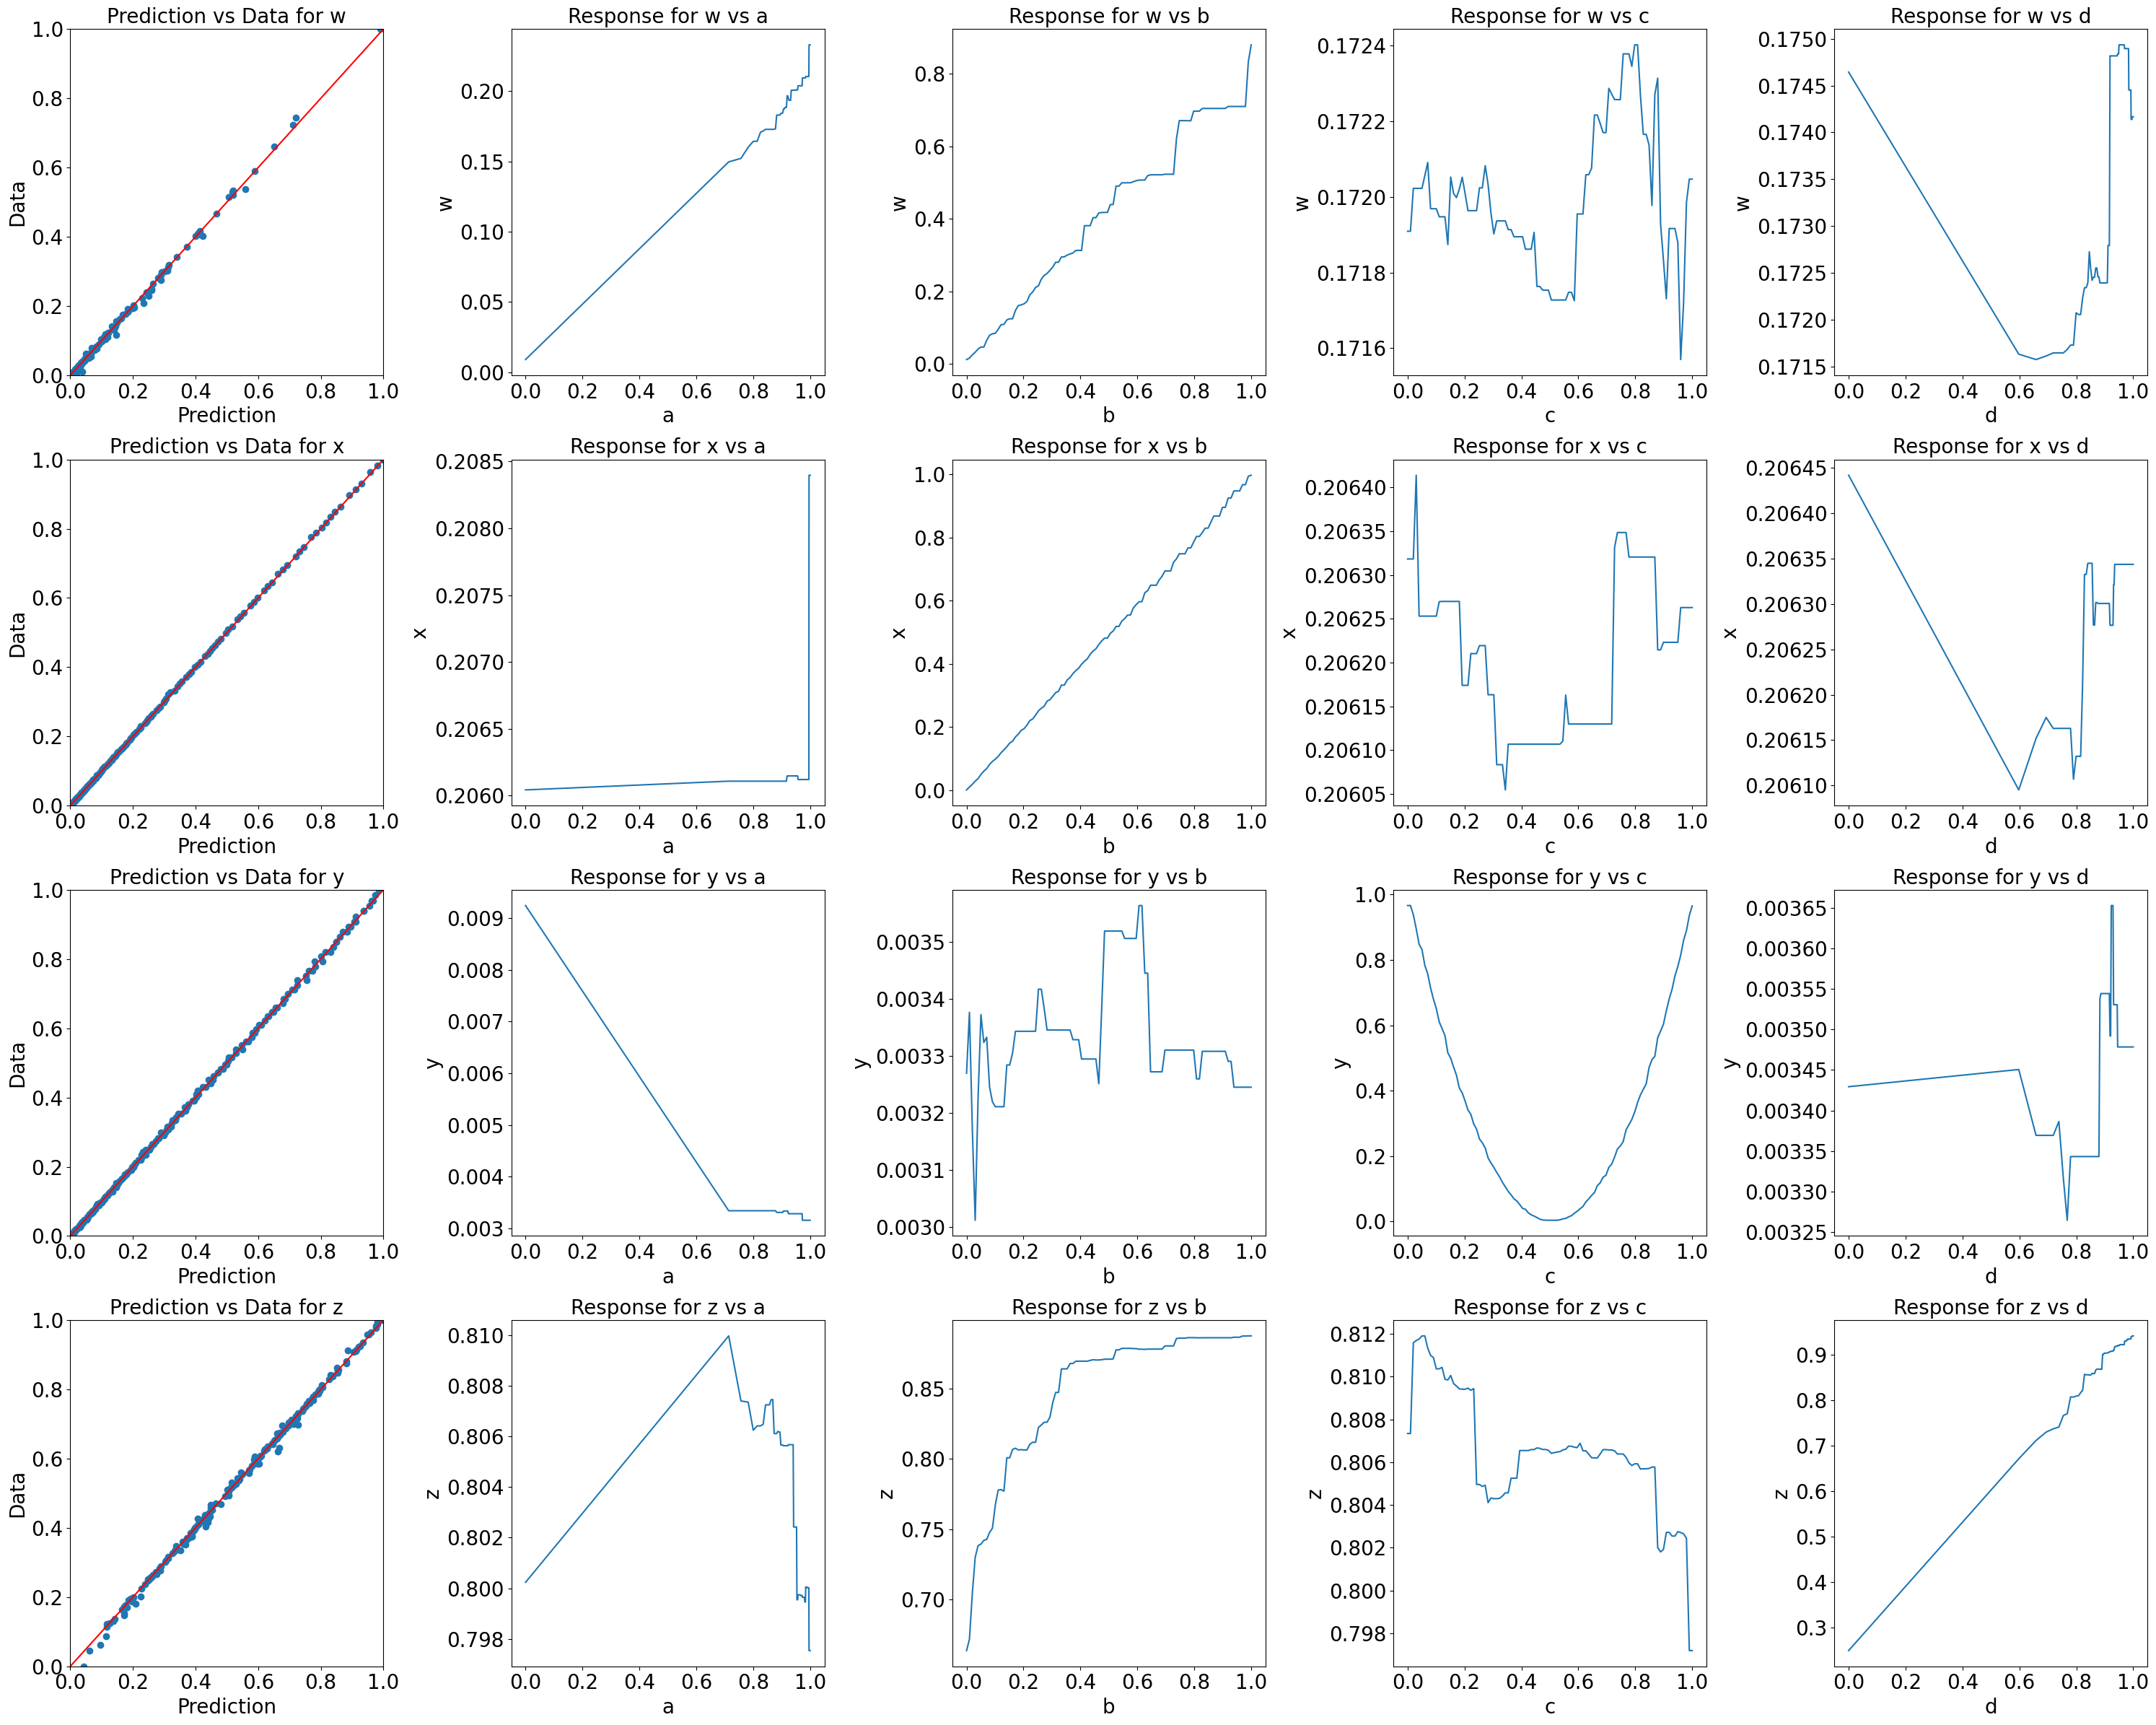

In [22]:
params_full = RegressorPlotParameters(ensemble, app.factors.mean(), app.factors.min(), app.factors.max())
reg_plot_full = RegressorPlot(params_full)
reg_plot_full.plot_scaled()